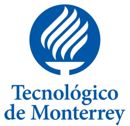

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Navegación autónoma**
### Tecnológico de Monterrey
###  	Dr. David Antonio Torres

#### **Actividad 4.2 - Detección de Señales de Tránsito**
____


**Nombres y matrículas de los integrantes del equipo:**

*   Julio Cesar Lynn Jimenez A01793660
*   Francisco Javier Parga García A01794380
*   Carlos Roberto Torres Ferguson A01215432
*   Fernando Sebastian Sanchez Cardona A01687530

____

# Clasificación de señales de transito con CNN

> Mediante un modelo convolucional, se creó u clasificador para identificar el tipo de señalización, utilizando los datos para entrenamiento de GTRSB

In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (5,3)

## Datos para entrenamiento y validación

In [2]:
train_directory = 'data/Train'
test_directory = 'data/Test'

In [3]:
# Crea un generador con aumento de datos
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='nearest',
                                   validation_split=0.25)

In [4]:
# Definicion de variables para batch y tamaño de imagen a usar
batch_size = 128
image_size = (28,28)

# Keras ImageDataGenerator proporciona un método flow_from_directory para cargar imágenes en lotes
# Esto es útil para conjuntos de datos grandes que no caben en la memoria
train_generator = train_datagen.flow_from_directory(train_directory,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    classes= list(map(str,range(0,43))),
                                                    subset='training')  # establece como datos de entrenamiento

validation_generator = train_datagen.flow_from_directory(train_directory,  # mismo directorio que los datos de entrenamiento
                                                         target_size=image_size,
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         classes=  list(map(str,range(0,43))),
                                                         subset='validation')  # establece como datos de validación


Found 29416 images belonging to 43 classes.
Found 9793 images belonging to 43 classes.


## Modelo CNN para clsificación

In [5]:
#Modelo CNN 
def initialize_model():
    model = Sequential()

    ### Primera convolución y MaxPooling
    model.add(Conv2D(32, (3,3),padding = "same", input_shape=image_size+(3,), activation="relu"))
    model.add(Conv2D(32, (3,3), activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    #model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    ### Tercera convolución
    model.add(Conv2D(64, (3,3), padding='same', activation="relu"))
    model.add(Conv2D(64, (3,3), activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    #model.add(BatchNormalization())
    model.add(Dropout(0.25))

    ### Aplanamiento
    model.add(Flatten())
    
    ### Una capa "Dense"
    model.add(Dense(392, activation='relu'))
    model.add(Dropout(0.5))
    

    ### Última capa con 43 salidas
    model.add(Dense(43, activation='softmax')) #Softmax(43)  
    return model


def compile_model(model):

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy', 'Recall', 'Precision']) 
    return model

In [6]:
model_keras = initialize_model()
model_keras = compile_model(model_keras)

model_keras.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        36928     
                                                        

In [7]:
# Crea un callback de EarlyStopping que detiene el entrenamiento cuando el accuracy de validación deja de mejorar
early_stop = EarlyStopping(monitor = 'val_accuracy', 
                           mode = 'max', 
                           patience = 7,  
                           restore_best_weights = True,
                           verbose=1)

# Crea un callback de ModelCheckpoint que guarda el modelo con la mejor accuracy de validación
model_checkpoint = ModelCheckpoint('best_model.h5', 
                                   monitor='val_accuracy', 
                                   mode='max', 
                                   verbose=1, 
                                   save_best_only=True)

## Entrenamientoo de modelo CNN

In [8]:
%%time

history = model_keras.fit(train_generator,
                            epochs=101,
                            validation_data=validation_generator,
                            callbacks=[early_stop, model_checkpoint]) 

Epoch 1/101
229/230 [============================>.] - ETA: 0s - loss: 2.2237 - accuracy: 0.3723 - recall: 0.2011 - precision: 0.7761
Epoch 1: val_accuracy improved from -inf to 0.65006, saving model to best_model.h5
230/230 [==============================] - 17s 60ms/step - loss: 2.2190 - accuracy: 0.3734 - recall: 0.2024 - precision: 0.7761 - val_loss: 1.1673 - val_accuracy: 0.6501 - val_recall: 0.4419 - val_precision: 0.8339
Epoch 2/101
230/230 [==============================] - ETA: 0s - loss: 0.7952 - accuracy: 0.7392 - recall: 0.6337 - precision: 0.8521
Epoch 2: val_accuracy improved from 0.65006 to 0.78679, saving model to best_model.h5
230/230 [==============================] - 13s 57ms/step - loss: 0.7952 - accuracy: 0.7392 - recall: 0.6337 - precision: 0.8521 - val_loss: 0.6740 - val_accuracy: 0.7868 - val_recall: 0.7178 - val_precision: 0.8693
Epoch 3/101
229/230 [============================>.] - ETA: 0s - loss: 0.4520 - accuracy: 0.8499 - recall: 0.8032 - precision: 0.8981

### Resultados de entrenamiento

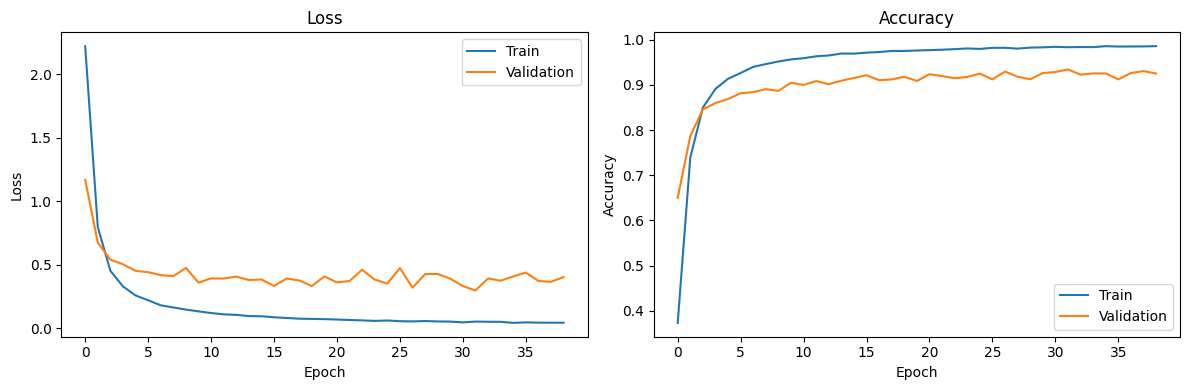

In [9]:
# Plot the loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

## Evalución de modelo de clasificación

In [6]:
# Cargar la tabla pandas con las rutas de las imágenes y las clases
df = pd.read_csv("data/Test.csv")

# Definir una función que carga una imagen desde una ruta y la preprocesa
def load_image(path):
  # Leer el archivo de imagen
  image = tf.io.read_file(path)
  # Decodificar la imagen como JPEG
  image = tf.image.decode_png(image, channels=3)
  # Cambiar el tamaño de la imagen a un tamaño fijo
  image = tf.image.resize(image, image_size)
  # Normalizar los valores de píxeles al rango [0, 1]
  image = image / 255.0
  return image

# Definir una función que carga un lote de imágenes y etiquetas desde la tabla pandas
def load_batch(df, batch_size):
  # Barajar la tabla
  df = df.sample(frac=1).reset_index(drop=True)
  # Recorrer la tabla en lotes
  for i in range(0, len(df), batch_size):
    # Obtener el lote de rutas y clases
    batch_paths = df["Path"][i:i+batch_size]
    batch_classes = df["ClassId"][i:i+batch_size]
    # Cargar el lote de imágenes
    batch_images = [load_image('data/' + path) for path in batch_paths]
    # Convertir el lote de imágenes y etiquetas en tensores
    batch_images = tf.stack(batch_images)
    # Convertir el lote de etiquetas en tensores categóricos
    batch_labels = tf.keras.utils.to_categorical(batch_classes, num_classes=43)
    yield batch_images, batch_labels

# Definir una función de cargador de datos que usa la función load_batch
def data_loader(df, batch_size):
  # Crear un conjunto de datos a partir de la función load_batch
  dataset = tf.data.Dataset.from_generator(
                                        lambda: load_batch(df, batch_size),
                                        output_types=(tf.float32, tf.float32),
                                        output_shapes=([None, image_size[0], image_size[1], 3], [None, None])
  )
  return dataset

# Crear un cargador de datos con un tamaño de lote de 32
data_loader = data_loader(df, 32)

In [7]:
# Cargar el mejor modelo
model = tf.keras.models.load_model("best_model.h5")

# Evlauar el modelo con los datos de Test
model.evaluate(data_loader)

395/395 [==============================] - 113s 277ms/step - loss: 0.2606 - accuracy: 0.9435 - recall: 0.9408 - precision: 0.9494


[0.2606205344200134, 0.943467915058136, 0.9407759308815002, 0.949420690536499]

# Modelo para detección de señales en el video

> Para complementar la clasificación de las señales de tránsito, se utilizó el set de datos de GTSDB (German Traffic Sign Detection Benchmark) el cual es una evaluación de detección de imágenes individuales para investigadores con interés en el campo de la visión por computadora, el reconocimiento de patrones y la asistencia al conductor basada en imágenes. Se supone que se presentará en la IEEE International Joint Conference on Neural Networks 2013:
>
> https://benchmark.ini.rub.de/gtsdb_news.html

## Datos de entrenamiento

In [5]:
path_dir="data/YOLO_data/FullIJCNN2013/"

data = pd.read_csv(path_dir+'gt.txt',sep=';',names=['path','left','top','right','bottom','id'])
data.head()

,path,left,top,right,bottom,id
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39


(800, 1360, 3)


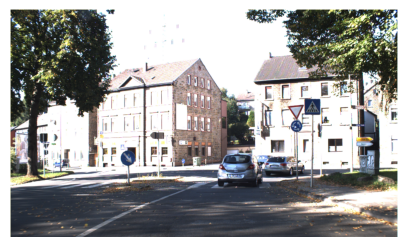

In [7]:
from PIL import Image
#opening image and converting it into numpy array and checking the size of array.
img = Image.open(path_dir+data['path'][0])
img=np.array(img)
print(img.shape)

img = Image.open(path_dir+data['path'][1])
img=np.array(img)
plt.axis('off')
plt.imshow(img[:,:,:])
plt.show()

In [8]:
#copiando la columna id de los datos en df
df = data['id'].copy()
data ['Object Name'] = data['id']
#asignando una sola etiqueta para señal de trafico
for i in range(len(df)):
  if(df[i] in range(0,43)):
    df.loc[i]=0
    data['Object Name'].loc[i]='trafficsign'
  else:
    df.loc[i]=-1
data.head()

C:\Users\fgarcia24\AppData\Local\Temp\ipykernel_44008\1312309559.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Object Name'].loc[i]='trafficsign'


,path,left,top,right,bottom,id,Object Name
0,00000.ppm,774,411,815,446,11,trafficsign
1,00001.ppm,983,388,1024,432,40,trafficsign
2,00001.ppm,386,494,442,552,38,trafficsign
3,00001.ppm,973,335,1031,390,13,trafficsign
4,00002.ppm,892,476,1006,592,39,trafficsign


## Ajustes de dato para el entrenamiento

In [9]:
import cv2

#Remover la extension en la columna de path
data['path'] = data['path'].str.slice(0, -4)

# Usando os.walk para recorrer todos los directorios
# y archivos en ellos desde el directorio actual
path_dir="data/YOLO_data/FullIJCNN2013/"
final_df=pd.DataFrame(columns=data.columns)
df_list = [] # crear una lista vacía de DataFrames
for current_dir, dirs, files in os.walk(path_dir):
    for f in files:
        #print(f)
        #Comprobar si un archivo termina con formato .ppm o no
        if f.endswith('.ppm'):
            image_name=f[:-4]
            img=cv2.imread(path_dir + f)
            single_yolo_dat = data.loc[data['path'] == image_name].copy()
            #print(single_yolo_dat)
            # y, de esta manera, el dataFrame inicial no se cambiará
            # Comprobando si no hay ninguna anotación para la imagen actual
            if single_yolo_dat.isnull().values.all():
                # Eliminando esta imagen de los datos de entrenamiento
                # print(f)
                os.remove(path_dir + f)
                
            #Ahora guardar el resulted_frame en una carpeta dentro de path_dir
            else:
              df_list.append(single_yolo_dat) # añadir a la lista de DataFrames
              #Ahora escribiendo y guardando la imagen de formato ppm a formato jpg usando OpenCV
              save_path = 'data/YOLO_data/jpeg_files/' + image_name + '.jpg'
              cv2.imwrite(save_path, img)

final_df = pd.concat(df_list) # concatenar la lista de DataFrames
final_df = final_df[~final_df.index.duplicated(keep='first')]
final_df.sort_index(inplace=True)

## División del dato para entrenamiento y validación

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(final_df['path'].unique(), test_size=0.2, random_state=37)
train.shape, test.shape

((592,), (149,))

## Creación de etiquetas para entrenamiento y validación

In [ ]:
labels_path = 'data/YOLO_data/labels/'

# Crear una carpeta para almacenar los archivos de etiquetas
os.makedirs(labels_path, exist_ok=True)
os.makedirs(labels_path+'train/', exist_ok=True)
os.makedirs(labels_path+'test/', exist_ok=True)

# Recorrer cada imagen en la tabla
for path, group in final_df.groupby('path'):
    # Obtener el nombre de la imagen sin extensión
    if path in train:
        name = labels_path+'train/'+path+'.txt'
    elif path in test:
        name = labels_path+'test/'+path+'.txt'
    # Abrir un archivo de texto con el mismo nombre que la imagen
    with open(name, 'w') as f:
        # Recorrer cada objeto en la imagen
        for row in group.itertuples():
            # Obtener el id de clase del objeto, las coordenadas izquierda, superior, derecha e inferior
            class_id = 0 #row.id   # modificado para detectar cualquier señal de tráfico
            left = row.left
            top = row.top
            right = row.right
            bottom = row.bottom
            # Calcular el centro normalizado x, y, ancho y alto del cuadro delimitador
            x = round((left + right) / 2 / 1360,2) # ancho de la imagen
            y = round((top + bottom) / 2 / 800,2) # altura de la imagen
            w = round((right - left) / 1360,2)
            h = round((bottom - top) / 800,2)
            
            # Escribir los datos de la etiqueta en el archivo de texto en formato YOLOv8
            f.write(f'{class_id} {x} {y} {w} {h}\n')

### División de las imágenes deacuerdo a las listas de entrenamiento y validación

In [13]:
import shutil

jpeg_files = 'data/YOLO_data/jpeg_files/'
images_path = 'data/YOLO_data/images/'

# Crear las carpetas de entrenamiento y prueba si no existen
os.makedirs(images_path, exist_ok=True)
os.makedirs(images_path+'train/', exist_ok=True)
os.makedirs(images_path+'test/', exist_ok=True)

# Recorrer el array de entrenamiento y copiar las imágenes jpeg a la carpeta de entrenamiento
for image in train:
    # Obtener la ruta completa del archivo de imagen
    src = os.path.join(jpeg_files, image + '.jpg')
    # Copiar el archivo de imagen a la carpeta de entrenamiento
    shutil.copy(src, images_path+'train')

# Recorrer el array de prueba y copiar las imágenes jpeg a la carpeta de prueba
for image in test:
    # Obtener la ruta completa del archivo de imagen
    src = os.path.join(jpeg_files, image + '.jpg')
    # Copiar el archivo de imagen a la carpeta de prueba
    shutil.copy(src, images_path+'test')

## Entrenamiento de modelo YOLO

In [14]:
import torch
from ultralytics import YOLO

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [15]:
model = YOLO('yolov8s.yaml').load('yolov8s.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

In [16]:
%%time
results = model.train(data='yolo-trafficsigns.yaml', epochs=83, imgsz=640, verbose=True, patience=13, single_cls=True, 
                      conf=0.5, iou=0.7,
                      project='trafficsigns_yolo8s_640', name='train', pretrained=True, optimizer='SGD', 
                      dropout=0.1, cls=0.5,
                      device=0, workers=16, batch=32, save_conf=True,
                      augment=True, mosaic=False, mixup=False, 
                      degrees=7, flipud=0, scale=0.1,
                      hsv_v=0.75, hsv_h=0.085, hsv_s=0.75
                     )

Ultralytics YOLOv8.0.106  Python-3.9.16 torch-2.0.1+cu117 CUDA:0 (NVIDIA RTX A4500 Laptop GPU, 16384MiB)
yolo\engine\trainer: task=detect, mode=train, model=yolov8s.yaml, data=yolo-trafficsigns.yaml, epochs=83, patience=13, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=16, project=trafficsigns_yolo8s_640, name=train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=0.5, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=True, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=

CPU times: total: 2min 15s
Wall time: 8min 49s


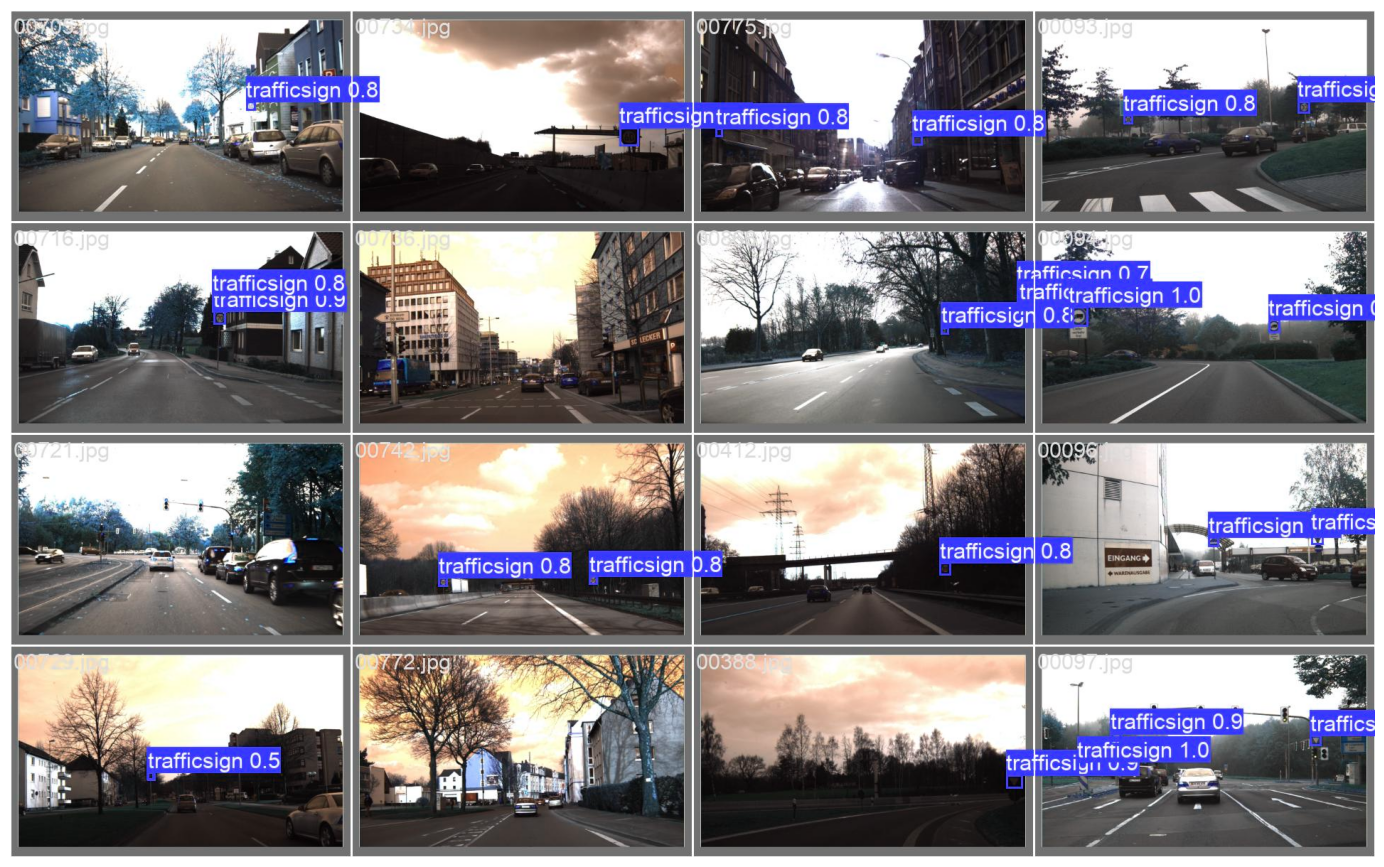

In [20]:
road_img = cv2.imread('trafficsigns_yolo8s_640/train2/val_batch1_pred.jpg')

plt.figure(figsize=(20,11))
plt.imshow(road_img)
plt.axis('off')
plt.show()

# Detector de senales de trafico integrado

In [21]:
classes = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons'
}

In [22]:
from tqdm.auto import tqdm
from PIL import Image
import tensorflow as tf

class TrafficSignDetector:
    def __init__(self, model_detec, model_classify):
        self.model_detec = model_detec
        self.model_classify = model_classify

    def process_frame(self, img):
        # Definir los parámetros para deteccin de señales de trafico
        passed_frame = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #Deteccion de se;ales de transito con YOLO
        detected_trafficsigns = self.model_detec.predict(source=passed_frame, save=False, conf=0.1, verbose=False)
        boxes = detected_trafficsigns[0].boxes.xyxy.cpu().data.numpy().astype(int)

        # Definir una función para redimensionar y normalizar una imagen
        def preprocess_image(image):
            image = tf.image.resize(image, (28, 28))
            image = tf.cast(image, tf.float32)
            image = image/255
            return image

        #Función para crear una caja cuadrada en la señal detectadda
        def get_squered_box(box):
            extend = 1
            w = box[2]-box[0]
            h = box[3]-box[1]
            
            long = (max(w,h)/2)+extend
            
            center = (np.mean([box[2],box[0]]).astype(int),np.mean([box[3],box[1]]).astype(int))
            
            square_box = np.array([center[0]-long, center[1]-long,
                                   center[0]+long, center[1]+long]).astype(int)
            return square_box, long

        # Clasificación de cada señal detectada dentro el frame
        if boxes.shape[0] >0:
            for sign in boxes:
                square_box, long = get_squered_box(sign)
                cropped_sign = img[square_box[1]:square_box[3],square_box[0]:square_box[2]]
    
                # Convertir la región de interés en un tensor de TensorFlow y normalizar
                roi_tensor = preprocess_image(np.array(cropped_sign))
                roi_tensor = tf.expand_dims(roi_tensor, axis=0)
    
                # Predecir qué tipo de señal de tránsito fue eocntrada en la región de interés
                self.prediction = self.model_classify.predict(roi_tensor, verbose=0)
                self.trafic_class = classes.get(np.argmax(self.prediction))
                
                # Si se detecta una señal de tránsito, dibujar un rectángulo alrededor de la región de interés
                if tf.reduce_any(tf.greater_equal(self.prediction, 0.9)):
                    cv2.rectangle(img, (sign[0], sign[1]), (sign[2], sign[3]), (0, 255, 0), 2)
                    cv2.putText(img, self.trafic_class, (sign[0], sign[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
                    #print('Traficsignal')


        return img

    def process_video(self, input_video_path, output_video_path, start_at=3600, fracction_to_process=0.1):
        frame_set_no=start_at
        cap = cv2.VideoCapture(input_video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_set_no)
        
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Calcular el número de fotogramas a procesar (el 10% de los fotogramas totales)
        num_frames_to_process = int(total_frames * fracction_to_process)

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

        pbar = tqdm(total=num_frames_to_process, ncols=80, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}',
                    position=0, leave=True)

        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                try:
                    # Procesar el fotograma con el detector de señales de tráfico
                    result_frame = self.process_frame(frame)
                    # Escribir el fotograma procesado en el archivo de salida
                    out.write(result_frame)
                    #cv2.imshow('Processed Frame', result_frame)
    
                    pbar.update(1)
                    frame_count += 1
    
                    if frame_count >= num_frames_to_process:
                        break
    
                    #if cv2.waitKey(1) & 0xFF == ord('q'):
                    #    break
                except:
                    pass
            else:
                break

        pbar.close()

        cap.release()
        out.release()
        #cv2.destroyAllWindows()

In [23]:
from ultralytics import YOLO

input_video_path = 'dash_cam.mp4'
output_video_path = 'dash_cams_cnn-Keras.mp4'

model_detec = YOLO('trafficsigns_yolo8s_640/train/weights/best.pt')
model_classify = tf.keras.models.load_model("best_model.h5")

In [24]:
%%time
# Crear una instancia de PedestrianDetector con svc_model como el modelo a usar
traffic_sign_detector = TrafficSignDetector(model_detec, model_classify)

# Procesar el archivo de vídeo de entrada y guardar el archivo de vídeo de salida usando el método process_video
traffic_sign_detector.process_video(input_video_path, output_video_path, start_at=3600, fracction_to_process=0.2)

  0%|                                                                   | 0/3990

CPU times: total: 7min 29s
Wall time: 6min 24s


# Resultado de video procesado

El resultado procesado puede encontrarse en el link de youtube:
> https://youtu.be/ErCkWxos-EI